<a href="https://colab.research.google.com/github/maragraziani/InterpretabilityVISUM22/blob/main/Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VISUM 2022 - Exaplainable AI 

<figure class="image">
  <img src="https://github.com/maragraziani/InterpretabilityVISUM22/blob/main/images/intro.png?raw=1" width="750">
</figure>

mara.graziani@hevs.ch ; <a href="https://twitter.com/mormontre">@mormontre</a>

<figure class="image">
  <img src="https://github.com/maragraziani/InterpretabilityVISUM22/blob/main/images/structure.png?raw=1" width="750">
</figure>

<figure class="image">
  <img src="https://github.com/maragraziani/InterpretabilityVISUM22/blob/main/images/methods.png?raw=1" width="750">
</figure>

**References**
* Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. 2017.
* Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
* Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "" Why should i trust you?" Explaining the predictions of any classifier." Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 2016.
* Graziani, Mara, et al. "Sharpening Local Interpretable Model-Agnostic Explanations for Histopathology: Improved Understandability and Reliability." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2021.
* Kim, Been, et al. "Interpretability beyond feature attribution: Quantitative testing with concept activation vectors (tcav)." International conference on machine learning. PMLR, 2018.
* Graziani, Mara, Vincent Andrearczyk, and Henning Müller. "Regression concept vectors for bidirectional explanations in histopathology." Understanding and Interpreting Machine Learning in Medical Image Computing Applications. Springer, Cham, 2018. 124-132.

### Exploring further
If you want to further dive into the research in Interpretable AI, do not hesitate to look into the following toolboxes:
- Introduction to AI Interpretability - [Online course](https://introinterpretableai.wordpress.com)
- [Captum for PyTorch](https://captum.ai/)
- [Explainable AI 360](https://aix360.mybluemix.net/)
- [Quantus](https://github.com/understandable-machine-intelligence-lab/Quantus). I would like to thank Anna Hedström (<hedstroem.anna@gmail.com>) for her insights on XAI evaluation toolbox that she developed. For any questions concerning Quantus feel free to directly reach out to her. 


## Installation and Set up


In [2]:
!git clone https://github.com/maragraziani/InterpretabilityVISUM22.git

Cloning into 'InterpretabilityVISUM22'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 241 (delta 13), reused 1 (delta 1), pack-reused 212
Receiving objects: 100% (241/241), 11.26 MiB | 26.70 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [ ]:
!pip install captum opencv-python 
#!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [3]:
import sys
import warnings
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import os
import cv2
import PIL
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True
torch.cuda.empty_cache()
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

clear_output()

In [5]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2022-07-04 12:54:45--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.88.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.88.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2022-07-04 12:54:45 (19.7 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [10]:
# Loading the model 
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()

# Creating wrapper to access gradient values
class DenseNet(torch.nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = torchvision.models.densenet201(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1920))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

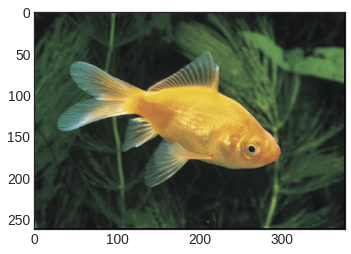

In [7]:
# load imagenet sample and apply standard transforms
imagenet_samples_dir = "/content/InterpretabilityVISUM22/data/imagenet/"
img = PIL.Image.open(imagenet_samples_dir+'n01443537/n01443537_goldfish.JPEG')
plt.imshow(img)
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
#plt.imshow(np.swapaxes(np.asarray(input[0]), 0,2))

In [8]:
images=[]
for image_dir in os.listdir(imagenet_samples_dir):
  if ".md" not in image_dir:
    for image_path in os.listdir(os.path.join(imagenet_samples_dir,image_dir)):
        dir_=os.path.join(imagenet_samples_dir,image_dir)
        image = PIL.Image.open(os.path.join(dir_, image_path))
        #transformed_img = transform(img)
        #input = transform_normalize(transformed_img)
        #input = input.unsqueeze(0)
        images.append(image) 
#transformed_inputs=torch.stack(tuple(transform_normalize(i) for i in images), dim=0)

## 1. Gradient-based methods

### Grad-CAM: Gradient-weighted Class Activation Mapping

#### Theory

> Grad-CAM is a post-hoc interpretability method that generates a localization map by visualizing the contribution of each feature map to the network prediction. The cascade of gradients is taken into account to weight the feature maps contributions.  

*   Easy-to-apply, intuitive, computationally fast
*   Optimal tool for initial debugging and to verify wrong behaviors
*   Limited to visual assessment, risk of confirmation bias

When should we use Grad-CAM?

* If you already have a trained deep learning model with good performance
* If you want to debug your model to verify expected behavior
* If you want to evaluate the network attention to the features for one class, against another class

The core idea behind Grad-CAM is that of Class Activation Mapping introduced by Zhou et al. (2016), as illustrated in the figure below.


<figure class="image">
  <img src="http://cnnlocalization.csail.mit.edu/framework.jpg" width="800">
</figure>

- The output of the convolutional layers are multiple feature maps of dimensions w x h x c.
- Global Average Pooling (GAP) takes the spatial average (on w and h) of each feature map to obtain a vector of dimension c.
- This vector is **weighted** by the last layer vector of weights W to determine the contributions to the classification layer.
- The heatmap is obtained by the weighted sum of each feature map, where W is used as weight.

### Extension to Gradient-weighted CAMs (Grad-CAM)
Grad-CAM generalizes CAM as it generates visual explanations by directly taking into account the cascade of gradients. 
This approach by-passes the need of a GAP operation and makes this method applicable to a wide variety of  models and applications, including image captioning and query answering. 
These two methods were shown to be equivalent up to anormalization constant that is proportional to the number of pixels in the feature maps [Selvaraju et al., 2017](http://gradcam.cloudcv.org/).

<figure class="image">
  <img src="http://gradcam.cloudcv.org/static/images/network.png" width="800">
</figure>

- The **weighting** vector is obtained by the propagation of the gradients. 
- The gradient for every feature map is used as a weight.
- A ReLU activation function is used to only retain positive activations.



#### Practice


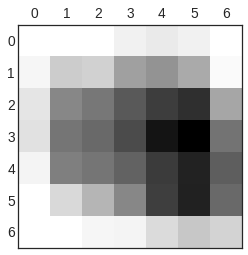

In [ ]:
# generating prediction from wrapped model
densenet = DenseNet()
pred = densenet(input)
class_idx = pred.argmax(dim=1).item()
pred[:, class_idx].backward()

# getting the gradients
gradients = densenet.get_activations_gradient()

# pooling the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# geting the activations of the last convolutional layer
activations = densenet.get_activations(input).detach()

# weighting the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# averaging the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalizing the heatmap
heatmap /= torch.max(heatmap)

# visualization
plt.matshow(heatmap.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


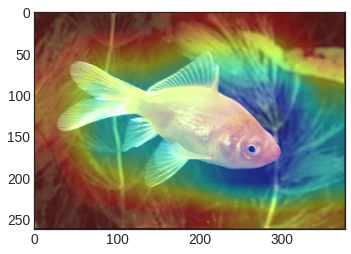

In [ ]:
# Mapping back to the original input image
img=np.asarray(img, dtype=np.float32)
heatmap = cv2.resize(np.asarray(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)
plt.imshow(np.asarray(superimposed_img, dtype=np.int))

#### Exercises

1.   Generate Grad-CAM for the classic Elephant image that François Chollet’s “Deep Learning With Python” book, reachable at this [link]("https://i.imgur.com/Bvro0YD.png"). Does the result point at the elephant's ears, as expected?

```
url="https://i.imgur.com/Bvro0YD.png"
img_path = PIL.Image.open(urlopen(url))
```

2.   Generate Visualizations for InceptionV3

3. Can you obtain the segmentation below, and how can you do that? How does the segmentation vary if you vary your hyperparameters (e.g. segmentation threshold)? 
<figure class="image">
  <img src="https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/raw/master/resources/images/output_64_1.png" width="100">
</figure> 

4. Can you use the segmentations above to evaluate the localization ability of Grad-CAM? 



### Integrated Gradients (with Captum)

#### Theory
From the paper "Axiomatic Attribution for Deep Networks":


> Integrated gradients aggregate the gradients along the inputs that fall on the straightline between the baseline and the input.
Specifically, integrated gradients are defined as the path intergral of the gradients along the straightline path from the baseline x′ to the input x.

> Consider the straightline path from the baseline x′ to the input x, and compute the gradients at all points along the path. Integrated gradients are obtained by cumulating these gradients.

#### Practice

In [ ]:
import captum
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients

del model
# Loading the model 
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()
output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)


Predicted: goldfish ( 0.9041939973831177 )


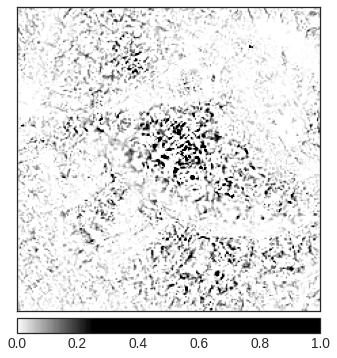

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## 2. LIME: Local Interpretable Model-agnostic Explanations


#### Theory

> In LIME, the decision function (blue, pink background in the image below) is approximated by a proxy model (often a linear regressor) in the locality of the datapoint being analyzed (red cross in the image). 
 
<figure class="image">
  <img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png" width="400">
</figure> 

The proxy model weights are then use to generate the explanation


*   Easy-to-apply, off-the-self
*   State-of-the-art, highly applied in multiple fields including medical imaging
*   Limited to visual assessment, risk of confirmation bias
* Highly sensitive to hyperparameter initiaization

When should we use LIME?

* To debug your model and obtain instance-wise explanations 
* If you already have a trained deep learning model with good performance


#### Practice

In [1]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 27.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=c55f92aba801b6533036cd09d9a3be393b0ea5d310480399463219b124d5de32
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


Predicted: red_wine ( 0.7952153086662292 )


  0%|          | 0/200 [00:00<?, ?it/s]

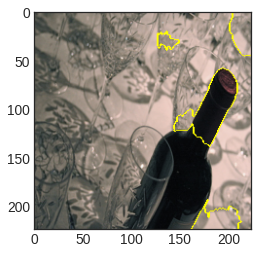

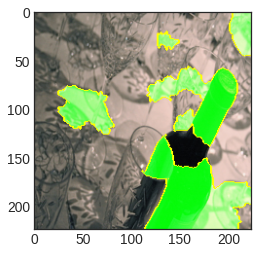

In [11]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf
pill_transf = get_pil_transform()

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]) 
    return transf
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

image_idx=1
input_img = transform_normalize(transform(images[image_idx])).unsqueeze(0)
output = model(input_img)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(np.asarray(pill_transf(images[image_idx])),
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=200) # number of images that will be sent to classification function


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.figure()
plt.imshow(img_boundry1)
print()
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure()
plt.imshow(img_boundry2)

#### Exercises 


## Sharp-LIME: Sharpening Local Interpretable Model-Agnostic Explanations

#### Theory
> For some applications the off-of-the-shelf implementation of LIME is not sufficient. 

* Sharp-LIME extends LIME by letting us control the input regions that are used to generate the explanations

<figure class="image">
  <img src="https://github.com/maragraziani/sharp-LIME/raw/main/images/logo.png" width="600">
  
</figure> 

* It generates more robust to hyper-parameter choices, more reliable and stable
* It provides us with increased explanation flexibility

When to use Sharp-LIME?

* If you are not satisfied with your LIME results
* If you want stable, reliable explanations to provide insights on what the model is learning
* To introduce control over which input areas are used for the explanation generation

#### Practice

In [ ]:
!git clone https://github.com/maftouni/binary_mask_from_json.git

fatal: destination path 'binary_mask_from_json' already exists and is not an empty directory.


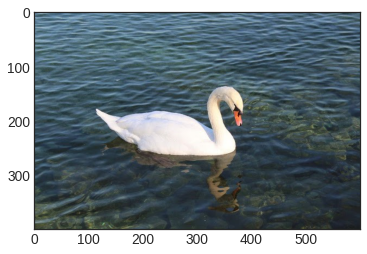

In [ ]:
img = PIL.Image.open("/content/binary_mask_from_json/sample_frames/adutta_swan.jpg")
plt.imshow(img)
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

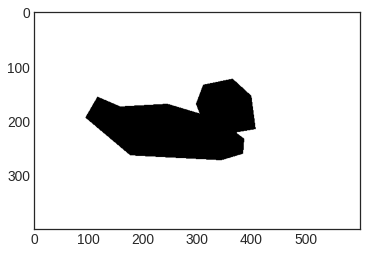

In [ ]:
mask = np.asarray(PIL.Image.open("/content/binary_mask_from_json/binary_masks/00000.png"))
plt.imshow(mask)

In [ ]:
mask2 = mask.copy()
mask2[:,:300] = 0

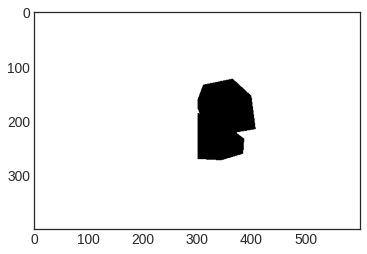

In [ ]:
plt.imshow(mask2)

In [ ]:
del model
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()
output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: goose ( 0.6745553016662598 )


In [ ]:
from lime import lime_image
def segfunc(img):
        return np.asarray(np.ones(mask.shape)-mask, dtype=np.int)
predict=model(input)
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(transform_normalize(transform(PIL.Image.fromarray(i))) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    probs = model(batch)
    #probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()
#quickshift_segs = segments_quickshift(im)
#Generate LIME explanation for class 1
explainer = lime_image.LimeImageExplainer()
class_idx = pred_label_idx.item()
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = None,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

In [ ]:
dict_genetic = dict(explanation_genetic.local_exp[class_idx])
heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
orig_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)

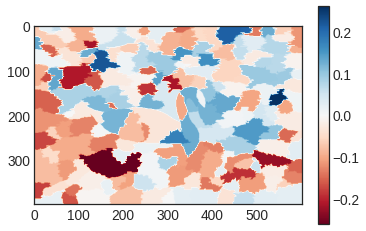

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

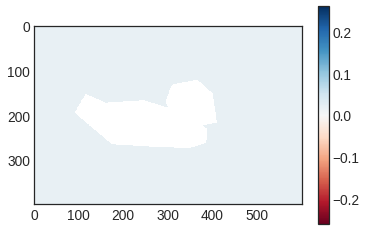

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
def segfunc(img):
        return np.asarray(np.ones(mask.shape)-mask2, dtype=np.int)

explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

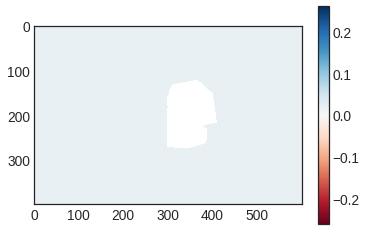

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
#def get_segments(mask):
squares = np.zeros(mask.shape[:2])
fract = int(mask.shape[0]/6)
fract1=int(mask.shape[1]/6)
counter = 0
for hor in range(6):
    for ver in range(6):
        squares[fract*hor:fract*(hor+1),fract1*ver:fract1*(ver+1)]=counter
        counter+=1

segments = (np.ones(mask.shape)-mask/5.) + squares
#print(np.unique(segments))

temp_renumber = [2+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

def segfunc(img):
        return segments
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

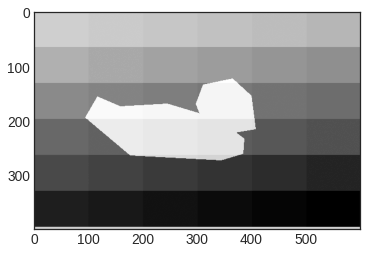

In [ ]:
plt.imshow(segments)

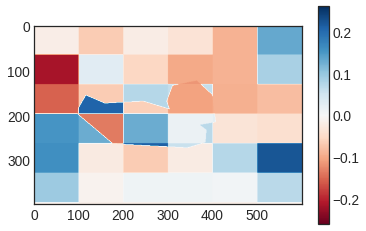

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## 3. Concept Attribution

### TCAV (with Captum)


#### Theory

Testing with Concept Activation Vectors (TCAV) is an interpretability method to understand what signals your neural networks models uses for prediction. TCAV shows the importance of high-level concepts, such as "striped texture" or "blue color" or "dotted texture" or "female sex" for a prediction class. 

There are three main steps for running TCAV:

1. Collect N random datasets, where it is recommended that N
is at least 10.
2. Fix the concept dataset = dataset representative of a concept that you would want to investigate. Calculate the TCAV score using each of the N random datasets
3. Apply a two-sided t-test to verify if your score for the selected dataset of interest (the concept dataset) is significantly higher than the random ones. 

How do you compute the TCAV score? 

1. Find the CAV 
2. Evaluate the sensitivity of the output with respect to the CAV over a dataset 
3. Ensamble the sensitivity scores obtained in two by a final measure or relevance 

* TCAV shows the importance of high level concepts (e.g., color, gender, race) for a prediction class - this is much closer to how humans communicate than showing the importance of raw input pixels (such as in CAM, Grad-CAM, saliency).
* TCAV learns concepts from examples. For instance, TCAV needs a couple of examples of female, and something not female to learn a "gender" concept.
You don't need to change or retrain your network to use TCAV.



#### Practice

In [ ]:
from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

def assemble_concept(name, id, concepts_path="data/tcav/image/concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [ ]:
import PIL.Image as Image
def get_tensor_from_filename(filename):
    img = PIL.Image.open(filename).convert("RGB")
    return transform(img)

concepts_path = "/content/InterpretabilityVISUM22/data/tcav/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzag", 1, concepts_path=concepts_path)
#dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)

random_0_concept = assemble_concept("random500_0", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("random500_1", 4, concepts_path=concepts_path)

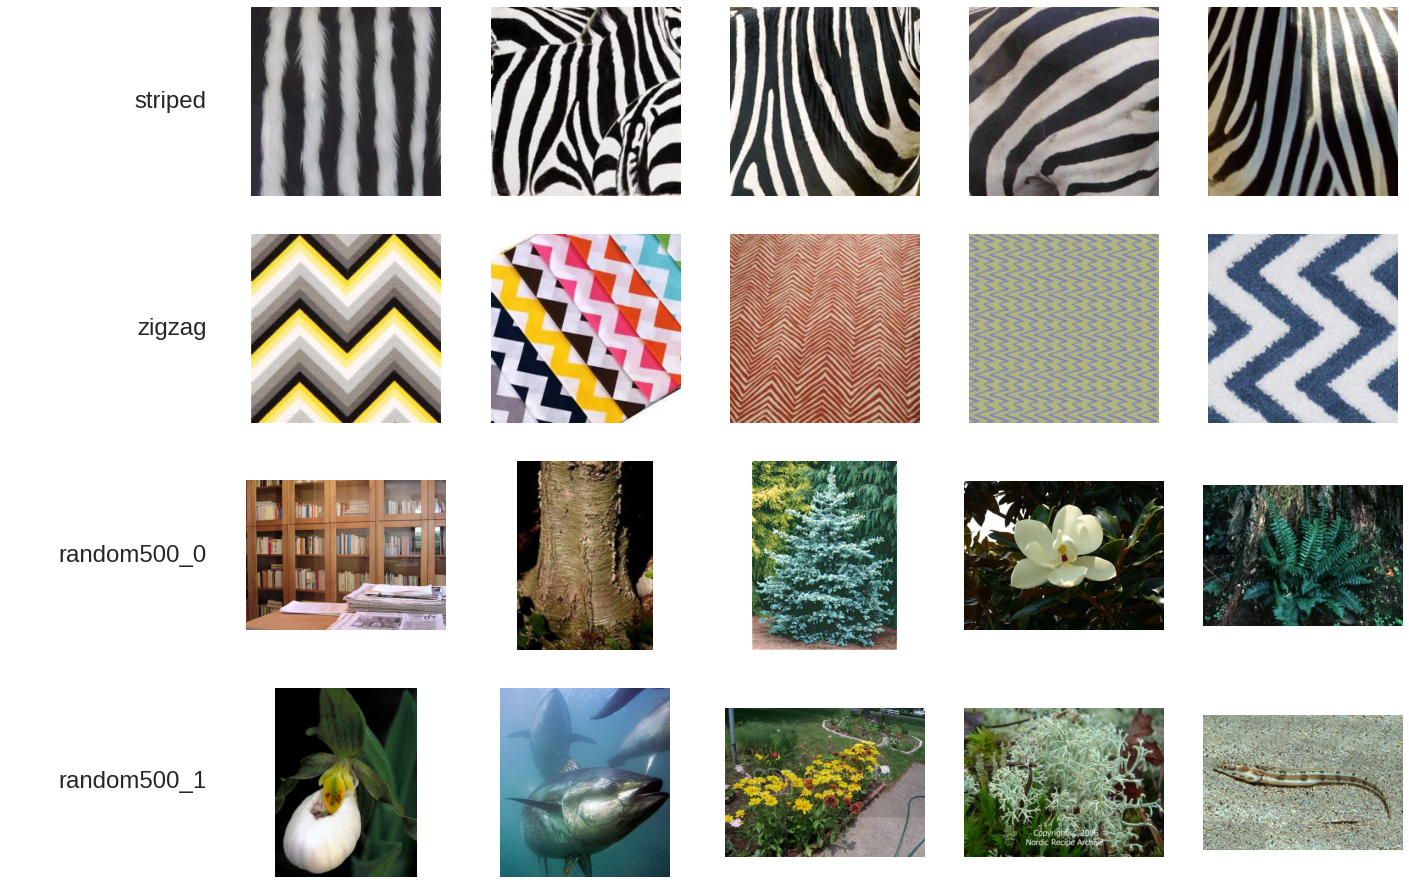

In [ ]:
import glob
n_figs = 5
n_concepts = 4

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [ ]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients
layers=['inception4c', 'inception4d', 'inception4e']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


In [ ]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]

In [ ]:
# Load sample images from folder
def load_image_tensors(class_name, root_path='data/tcav/image/imagenet/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = PIL.Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors
zebra_imgs = load_image_tensors('zebra', transform=False, root_path='/content/InterpretabilityVISUM22/data/tcav/')

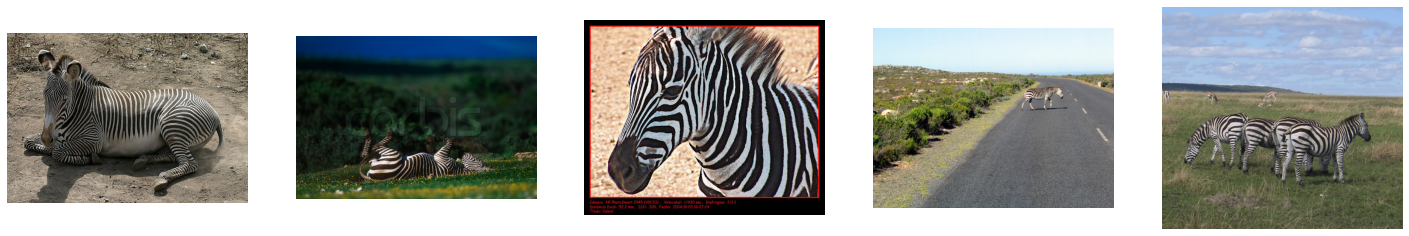

In [ ]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(zebra_imgs[0])
axs[1].imshow(zebra_imgs[1])
axs[2].imshow(zebra_imgs[2])
axs[3].imshow(zebra_imgs[3])
axs[4].imshow(zebra_imgs[4])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [ ]:
# Load sample images from folder
zebra_tensors = torch.stack([transform_normalize(transform(img)) for img in zebra_imgs])
experimental_set_rand

[[Concept(0, 'striped'), Concept(3, 'random500_0')],
 [Concept(0, 'striped'), Concept(4, 'random500_1')]]

In [ ]:
# zebra class index

zebra_ind = 340

tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>>,
            {'0-3': defaultdict(None,
                         {'inception4c': {'magnitude': tensor([ 1.7905, -1.7905]),
                           'sign_count': tensor([0.5714, 0.4286])},
                          'inception4d': {'magnitude': tensor([ 8.4330, -8.4330]),
                           'sign_count': tensor([1., 0.])},
                          'inception4e': {'magnitude': tensor([ 4.4899, -4.4899]),
                           'sign_count': tensor([1., 0.])}}),
             '0-4': defaultdict(None,
                         {'inception4c': {'magnitude': tensor([ 0.0210, -0.0210]),
                           'sign_count': tensor([0.7143, 0.2857])},
                          'inception4d': {'magnitude': tensor([ 3.5676, -3.5676]),
                           'sign_count': tensor([0.8571, 0.1429])},
                          'inception4e': {'magnitude': tensor([ 3.6036, -3.6036]),
                 

In [ ]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

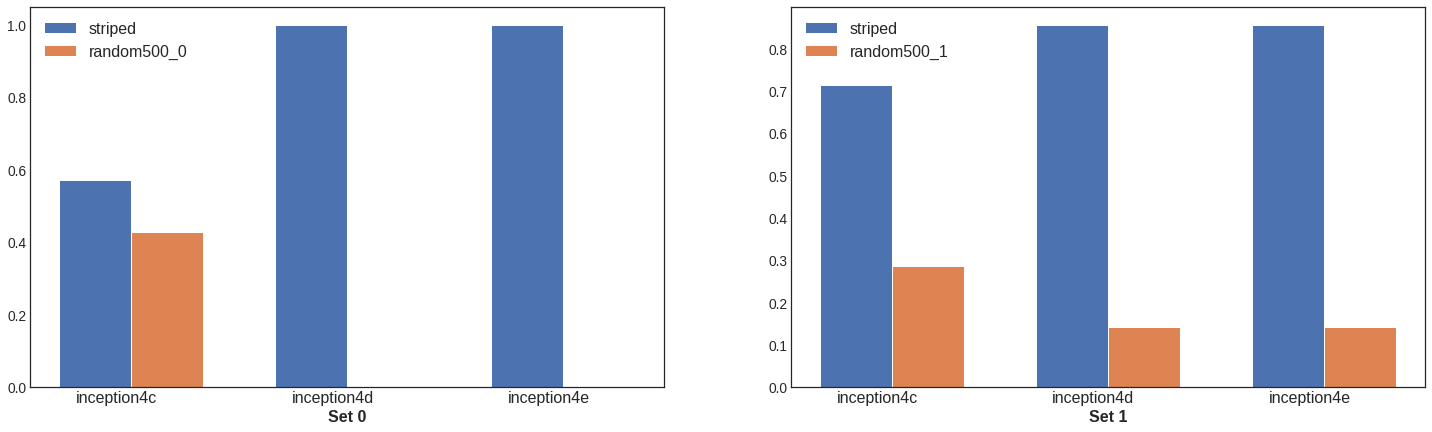

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

#### Exercises 
1. Change the model to mobile net and rerun the evaluation. What do you need to change to make this work (hint: maybe the bottleneck layer will need a different name?) How do the TCAV scores change? 
2. (Optional) Try TCAV on your model and images! 

### RCVs: Regression Concept Vectors

#### Theory

* We use RCVs to connect hand-crafted to deep features
- Similarly to feature attribution:
    - It preserves model performance
    - It is easy to apply 
    - It generates quantitative explanations, not only qualitative ones
    - **It explains in terms of arbitrary / hand-crafted features**

When should we use RCVs?

- If you already have a trained deep learning model with good performance
- For a deeper investigation about what factors are relevant in the decision-making
- **If you want to evaluate the relevance of specific features**
- If you want to investigate some specific network behaviours

## RCVs for image scale

- The bounding box of an object in your image can give you information about the object scale. One possible analysis is to measure bounding boxes ratios (in terms of bounding box area / entire image area) and to analyze the learning of this concept by state-of-the-art CNNs pretrained on ImageNet: https://www.mdpi.com/2504-4990/3/2/19

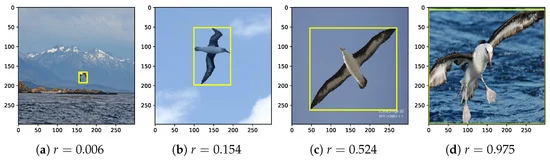

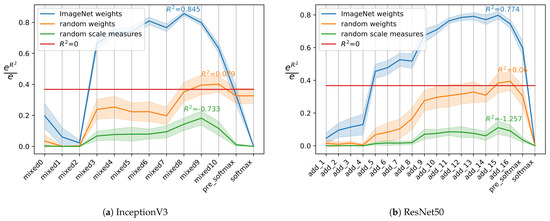


## RCVs for 1st and 2nd order statistics (pixel intensities and textures)

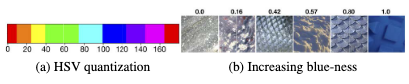

- individual measures of the percentage of a specificcolor in the image are computed by applying the color quantization of the HSV (Hue, Saturation, Value) space shown in the figure above. The  HSV  colorspace  is  closer  to  the  human representation of hue  ranges than RGB. For each of the eight bin quantizations, we define a distinct concept measure. For example, the blue-ness of the image is computed as #blue pixels/ #pixels. Images of the DTD dataset sorted for increasing values of their blue-ness in the image above. 

(15) (PDF) Interpreting Intentionally Flawed Models with Linear Probes. Available from: https://www.researchgate.net/publication/335946381_Interpreting_Intentionally_Flawed_Models_with_Linear_Probes [accessed Jun 07 2021].

## RCVs for histopathology

- We start from the Nottingham Histology Grading (NHG) of Breast Cancer
- Cancerous regions show atypical nuclei organization, morphology and mitotic activity
- Deformations in the nuclei morphology consist of:
    - **enlarged** size
    - **atypical** shape
    - **vesicular** appearance, visible nucleoli, high chromatism
- We model these diagnostic criteria as numeric features

<figure class="image">
  <img src="https://raw.githubusercontent.com/maragraziani/interpretAI_DigiPath/main/hands-on-session-1/imgs/rcvs.png" width="750">
</figure>

- We learn a **direction that is representative of these criteria** in the CNN: the RCV
- We evaluate, by the RCV, the relevance of these concept to the decision as a **conceptual sensitivity** score

#### Practice

In [13]:
!pip install rcvtool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rcvtool: filename=rcvtool-0.1.5-py3-none-any.whl size=8713 sha256=4eaf4b7421d9bcc3022afc4851d6e9be412f2313c717c24a843c9b91fe6b2998
  Stored in directory: /root/.cache/pip/wheels/04/26/53/351e5964f97145971f9c0e0fae50bdaac60e82e9ca904f4d1e
Successfully built rcvtool


In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras 
import matplotlib.pyplot as plt
import rcvtool
import numpy as np


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In the following, an example on how to use rcvtool to extract texture measures from an example image in MNIST digits


In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


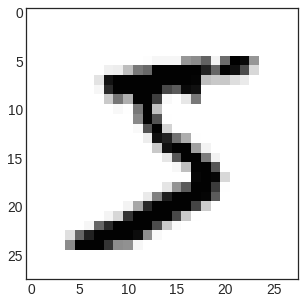

In [21]:
plt.rcParams['figure.figsize']=(5,5)
plt.imshow(x_train[0])

In [17]:
rcvtool.get_all_texture_measures(x_train[0])

/usr/local/lib/python3.7/dist-packages/rcvtool/rcv.py:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  skimage.img_as_ubyte(skimage.color.rgb2gray(image)),


{'ASM': array([[0.56878219]]),
 'contrast': array([[1789.86243386]]),
 'correlation': array([[0.86298341]]),
 'dissimilarity': array([[14.71164021]]),
 'energy': array([[0.7541765]]),
 'homogeneity': array([[0.80615506]])}

In [18]:
rcvtool.get_texture_measure(x_train[0], mtype='ASM')

/usr/local/lib/python3.7/dist-packages/rcvtool/rcv.py:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  skimage.img_as_ubyte(skimage.color.rgb2gray(image)),


array([[0.56878219]])

Now we move to natural images, in particular to evaluate the relevance of specific features in the classification of Zebra images


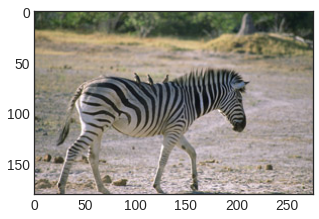

In [22]:
img = PIL.Image.open("InterpretabilityVISUM22/data/tcav/Zebra.jpg").convert('RGB')
plt.imshow(img)
sample_img=img

In [23]:
resized_sample = sample_img.resize((229,299), PIL.Image.NEAREST)
print(np.asarray(resized_sample).shape)
input_sample = np.zeros((2, 299,299,3))

(299, 229, 3)


Text(0.5, 1.0, 'Texture')

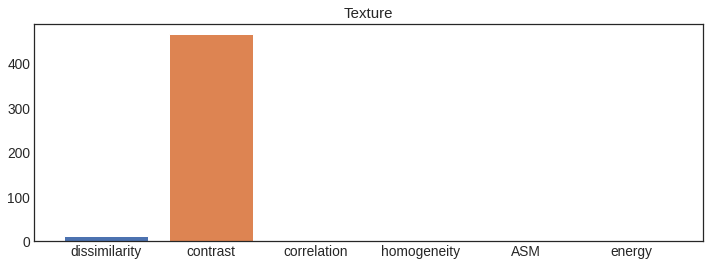

In [27]:
import cv2
plt.rcParams['figure.figsize']=(12,4)
img=np.asarray(resized_sample)
textures=rcvtool.get_all_texture_measures(img)
for k in textures.keys():
    plt.bar(k, textures[k][0])
plt.title("Texture")


Text(0.5, 1.0, 'Color')

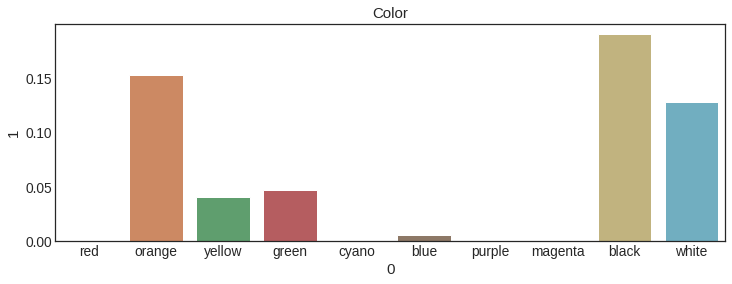

In [28]:
img_bgr=img[:, :, ::-1]
colors=rcvtool.get_all_color_measures(img_bgr, verbose=False)
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize']=(12,4)
data=pd.DataFrame(data={0: [k for k in colors.keys()], 1:[colors[k] for k in colors.keys()]})
fig=plt.figure()
sns.barplot(x=0, y=1,data=data.where(data!='colorfulness'))
plt.title("Color")
